In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [3]:
PATH = '/kaggle/input/utkface-new/UTKFace'

In [4]:
image_paths = []
age_labels = []

for filename in os.listdir(PATH):
    image_path = os.path.join(PATH, filename)
    temp = filename.split('_')
    age = int(temp[0])
    image_paths.append(image_path)
    age_labels.append(age)

In [5]:
X = np.array(image_paths)
y = np.array(age_labels)

In [6]:
def extract_features_with_upscaling(images, input_size=(32, 32), target_size=(128, 128)):
    features = []
    for image in images:
        # Load the image and resize to input_size (32x32)
        img = load_img(image, target_size=input_size)
        img = img_to_array(img)
        # Upscale to target_size (128x128) using bicubic interpolation
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)
        features.append(img)
    return np.array(features)

In [7]:
X = extract_features_with_upscaling(image_paths)
X /= 255.0

In [8]:
X_train, X_testval, y_train, y_testval = train_test_split(X, y, train_size=0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, train_size=0.5, random_state=42)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [10]:
def create_regression_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Regression output
    predicted_age = Dense(1, activation='linear', name='age_out')(x)

    model = Model(inputs=inputs, outputs=predicted_age)
    return model

regression_model = create_regression_model((128, 128, 3))

In [11]:
# Callbacks
model_save_path = '/kaggle/working/bi_coral_model.keras'
regression_model.save(model_save_path)

checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [12]:
regression_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='mse', 
    metrics=['mae']
)

history_regression = regression_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


593/593 ━━━━━━━━━━━━━━━━━━━━ 80s 124ms/step - loss: 465.4781 - mae: 16.6216 - val_loss: 294.9360 - val_mae: 13.2172 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 69s 115ms/step - loss: 310.4962 - mae: 13.5204 - val_loss: 221.8526 - val_mae: 11.4633 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 111ms/step - loss: 261.9466 - mae: 12.3050 - val_loss: 198.1333 - val_mae: 10.2000 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 67s 111ms/step - loss: 225.9221 - mae: 11.3972 - val_loss: 220.7058 - val_mae: 11.9966 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - loss: 207.7410 - mae: 10.8151 - val_loss: 140.3726 - val_mae: 8.7387 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 66s 111ms/step - loss: 184.4845 - mae: 10.2082 - val_loss: 141.9060 - val_mae: 8.6157 - learning_rate: 0.0010
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 69s 115ms/step - loss: 173.8551 - mae: 9.8749 - val_loss: 124

In [13]:
# Load the best model
model = tf.keras.models.load_model('/kaggle/working/bi_coral_model.keras')

In [14]:
loss, mae = model.evaluate(X_test, y_test, verbose=1)

print(f"Regression Mean Squared Error (MSE): {loss:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 81.9501 - mae: 6.5099
Regression Mean Squared Error (MSE): 80.636101
Regression Mean Absolute Error (MAE): 6.462948


In [21]:
# Predictions
y_pred = model.predict(X_test, verbose=1)

# Metrics Calculation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Regression Mean Squared Error (MSE): {mse:.4f}")
print(f"Regression Mean Absolute Error (MAE): {mae:.4f}")
print(f"Regression R² Score: {r2:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Regression Mean Squared Error (MSE): 80.6361
Regression Mean Absolute Error (MAE): 6.4629
Regression R² Score: 0.8013


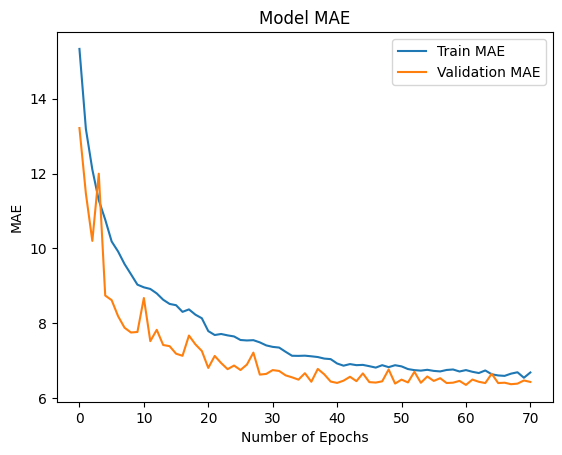

In [16]:
# Plot MAE
plt.plot(history_regression.history['mae'], label='Train MAE')
plt.plot(history_regression.history['val_mae'], label='Validation MAE')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('MAE')
plt.title('Model MAE')
plt.show()

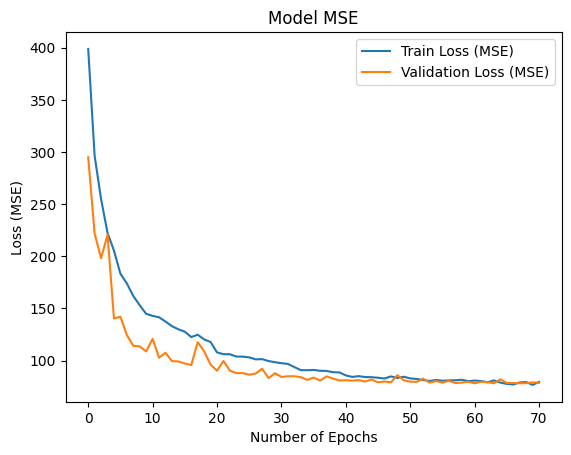

In [17]:
# Plot Loss (MSE)
plt.plot(history_regression.history['loss'], label='Train Loss (MSE)')
plt.plot(history_regression.history['val_loss'], label='Validation Loss (MSE)')
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model MSE')
plt.show()

In [18]:
test_img = load_img(image_paths[0], target_size=(32, 32))
test_img_array = img_to_array(test_img)

In [19]:
upscaled_img_array = cv2.resize(test_img_array, (128, 128), interpolation=cv2.INTER_CUBIC)

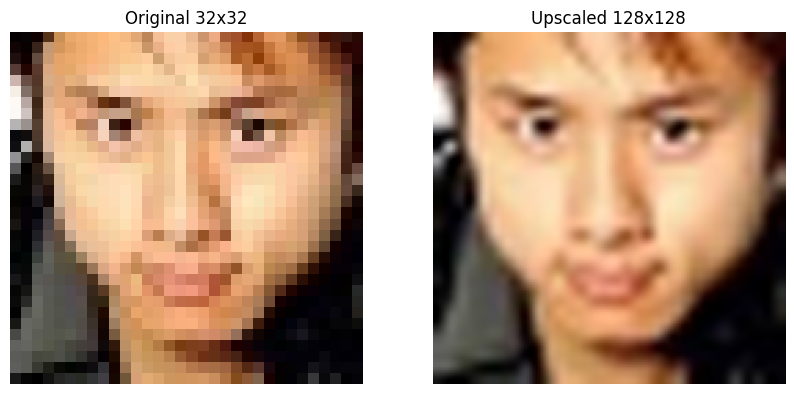

In [20]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_img_array / 255.0)
plt.title("Original 32x32")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(upscaled_img_array / 255.0)
plt.title("Upscaled 128x128")
plt.axis('off')
plt.show()